In [1]:
import numpy as np
from numpy.random import normal
import matplotlib.pyplot as plt
import matplotlib as mpl
import scipy
from scipy.interpolate import BSpline
from cmdstanpy import CmdStanModel
import arviz as az
import pandas as pd
from glob import glob
from sklearn import preprocessing
import csv

from DA_tools.DA_tools import ribbon_plot
from DA_tools.DA_colors import *

plt.style.context("seaborn-white")
mpl.rcParams["figure.dpi"] = 200


In [2]:
signals_healthy_x = np.zeros((10,), dtype = object)
signals_healthy_y = np.zeros((10,), dtype = object)
for i in range(10):
    a = pd.read_csv('processed_data1/signals_healthy_{}.csv'.format(i)) 
    signals_healthy_y[i] = a.to_numpy()[0]
    signals_healthy_x[i] = a.to_numpy()[1]

signals_damaged_1_y = np.zeros((10,), dtype = object)
signals_damaged_1_x = np.zeros((10,), dtype = object)
for i in range(10):
    a = pd.read_csv('processed_data1/signals_damaged_1_{}.csv'.format(i)) 
    signals_damaged_1_y[i] = a.to_numpy()[0]
    signals_damaged_1_x[i] = a.to_numpy()[1]

signals_damaged_2_y = np.zeros((10,), dtype = object)
signals_damaged_2_x = np.zeros((10,), dtype = object)
for i in range(10):
    a = pd.read_csv('processed_data1/signals_damaged_2_{}.csv'.format(i)) 
    signals_damaged_2_y[i] = a.to_numpy()[0]
    signals_damaged_2_x[i] = a.to_numpy()[1]

signals_damaged_ring_y = np.zeros((13,), dtype = object)
signals_damaged_ring_x = np.zeros((13,), dtype = object)
for i in range(13):
    a = pd.read_csv('processed_data1/signals_damaged_ring_{}.csv'.format(i)) 
    signals_damaged_ring_y[i] = a.to_numpy()[0]
    signals_damaged_ring_x[i] = a.to_numpy()[1]

In [3]:
LIGHT = "#B3FFFF"  # 179, 255, 255,
LIGHT_HIGHLIGHT = "#9AF6FF"  # 154, 246,255
MID = "#67C3FF"  # 103,195,255
MID_HIGHLIGHT = "#3490CC"  # 52,144,204
DARK = "#015D99"  # 1,93,153
DARK_HIGHLIGHT = "#002A66"  # 0,42,102
GREEN = "#00FF00"  # RGB
LIGHT_GREY = "#DDDDDD"  # RGB


In [4]:
def create_spline_matrix(time, spl_order=3, num_knots=10):
    """
    N - Number of time series,
    time - array/series of time values

    """
    knot_list = np.quantile(time, np.linspace(0, 1, num_knots))
    knots = np.pad(knot_list, (spl_order, spl_order), mode="edge")
    B = BSpline(knots, np.identity(num_knots + 2), k=spl_order)(time[0:len(time)])
    # Design matrix
    return B


In [5]:
# signals_damaged_y = np.array([])
# signals_damaged_y = np.append(signals_damaged_y,signals_damaged_1_y[:-2])
# signals_damaged_y = np.append(signals_damaged_y,signals_damaged_2_y[:-2])
# signals_damaged_y = np.append(signals_damaged_y,signals_damaged_ring_y[:-2])

# signals_damaged_x = np.array([])
# signals_damaged_x = np.append(signals_damaged_x,signals_damaged_1_x[:-2])
# signals_damaged_x = np.append(signals_damaged_x,signals_damaged_2_x[:-2])
# signals_damaged_x = np.append(signals_damaged_x,signals_damaged_ring_x[:-2])

In [6]:
IL1 = 3
IL2 = 3
IL3 = 3
IL4 = 3
IL = IL1 + IL2 + IL3 + IL4
I = 4


np.random.seed(21112022)

sampling_order_1 = np.random.permutation([*range(10)])
sampling_order_2 = np.random.permutation([*range(10)])
sampling_order_3 = np.random.permutation([*range(10)])
sampling_order_4 = np.random.permutation([*range(13)])
sampling_order_5 = np.random.permutation([*range(43 - IL)])


In [7]:

y_labeled = np.concatenate(
    [signals_healthy_y[sampling_order_1[:IL1]],
        signals_damaged_1_y[sampling_order_2[:IL2]],
        signals_damaged_2_y[sampling_order_3[:IL3]],
        signals_damaged_ring_y[sampling_order_4[:IL4]]]
)


labels = np.concatenate([np.ones(IL1), 2*np.ones(IL2),3*np.ones(IL3),4*np.ones(IL4)]).astype(int)


y_rest = np.concatenate(
    [signals_healthy_y[sampling_order_1[IL1:]],
        signals_damaged_1_y[sampling_order_2[IL2:]],
        signals_damaged_2_y[sampling_order_3[IL3:]],
        signals_damaged_ring_y[sampling_order_4[IL4:]]]
)

y_rest_time = np.concatenate(
    [signals_healthy_x[sampling_order_1[IL1:]],
        signals_damaged_1_x[sampling_order_2[IL2:]],
        signals_damaged_2_x[sampling_order_3[IL3:]],
        signals_damaged_ring_x[sampling_order_4[IL4:]]]
)


y_rest_labels = np.concatenate([np.ones(10-IL1), 2*np.ones(10-IL2),3*np.ones(10-IL3),4*np.ones(13-IL4)])

y = y_rest[sampling_order_5[:I]]
lambda0 = np.array([IL1/IL, IL2/IL,IL3/IL,IL4/IL])

y_test = y_rest[sampling_order_5[I:]]


IT = y_test.shape[0]
temp = np.array([])
N_labeled = np.array([])
for i in range(len(y_labeled)):
    N_labeled = np.append(N_labeled,len(y_labeled[i]))

In [8]:
N_labeled = np.array([])
temp = np.array([])
for i in range(len(y_labeled)):
    N_labeled = np.append(N_labeled,len(y_labeled[i]))
    temp = np.append(temp,y_labeled[i])
y_labeled = temp


N = np.array([])
temp = np.array([])
for i in range(len(y)):
    N = np.append(N,len(y[i]))
    temp = np.append(temp,y[i])
y = temp

N_test = np.array([])
temp = np.array([])
for i in range(len(y_test)):
    N_test = np.append(N_test,len(y_test[i]))
    temp = np.append(temp,y_test[i])
y_test = temp  

In [9]:
N_labeled = N_labeled.astype(int)
N = N.astype(int)
N_test = N_test.astype(int)


In [10]:
spl_order = 3
num_knots = 30
B0_labeled = np.array([])
B0_test = np.array([])
B0 = np.array([])
B0_rest = np.array([])
B0_rest_2 = np.array([])


for i in sampling_order_1[:IL1]:
    time = signals_healthy_x[i]
    knot_list = np.quantile(time, np.linspace(0, 1, num_knots))
    B0_healthy = create_spline_matrix(time, spl_order, num_knots)
    B0_healthy = B0_healthy.reshape(len(time)*(num_knots+2))
    B0_labeled = np.append(B0_labeled,B0_healthy)

for i in sampling_order_2[:IL2]:
    time = signals_damaged_1_x[i]
    knot_list = np.quantile(time, np.linspace(0, 1, num_knots))
    B0_damaged_1 = create_spline_matrix(time, spl_order, num_knots)
    B0_damaged_1 = B0_damaged_1.reshape(len(time)*(num_knots+2))
    B0_labeled = np.append(B0_labeled,B0_damaged_1)

for i in sampling_order_3[:IL3]:
    time = signals_damaged_2_x[i]
    knot_list = np.quantile(time, np.linspace(0, 1, num_knots))
    B0_damaged_2 = create_spline_matrix(time, spl_order, num_knots)
    B0_damaged_2 = B0_damaged_2.reshape(len(time)*(num_knots+2))
    B0_labeled = np.append(B0_labeled,B0_damaged_2)

for i in sampling_order_4[:IL4]:
    time = signals_damaged_ring_x[i]
    knot_list = np.quantile(time, np.linspace(0, 1, num_knots))
    B0_damaged_ring = create_spline_matrix(time, spl_order, num_knots)
    B0_damaged_ring = B0_damaged_ring.reshape(len(time)*(num_knots+2))
    B0_labeled = np.append(B0_labeled,B0_damaged_ring)

for i in sampling_order_5[:I]:
    time = y_rest_time[i]
    knot_list = np.quantile(time, np.linspace(0, 1, num_knots))
    B0_rest = create_spline_matrix(time, spl_order, num_knots)
    B0_rest = B0_rest.reshape(len(time)*(num_knots+2))
    B0 = np.append(B0,B0_rest)

for i in sampling_order_5[I:]:
    time = y_rest_time[i]
    knot_list = np.quantile(time, np.linspace(0, 1, num_knots))
    B0_rest_2 = create_spline_matrix(time, spl_order, num_knots)
    B0_rest_2 = B0_rest_2.reshape(len(time)*(num_knots+2))
    B0_test = np.append(B0_test,B0_rest_2)


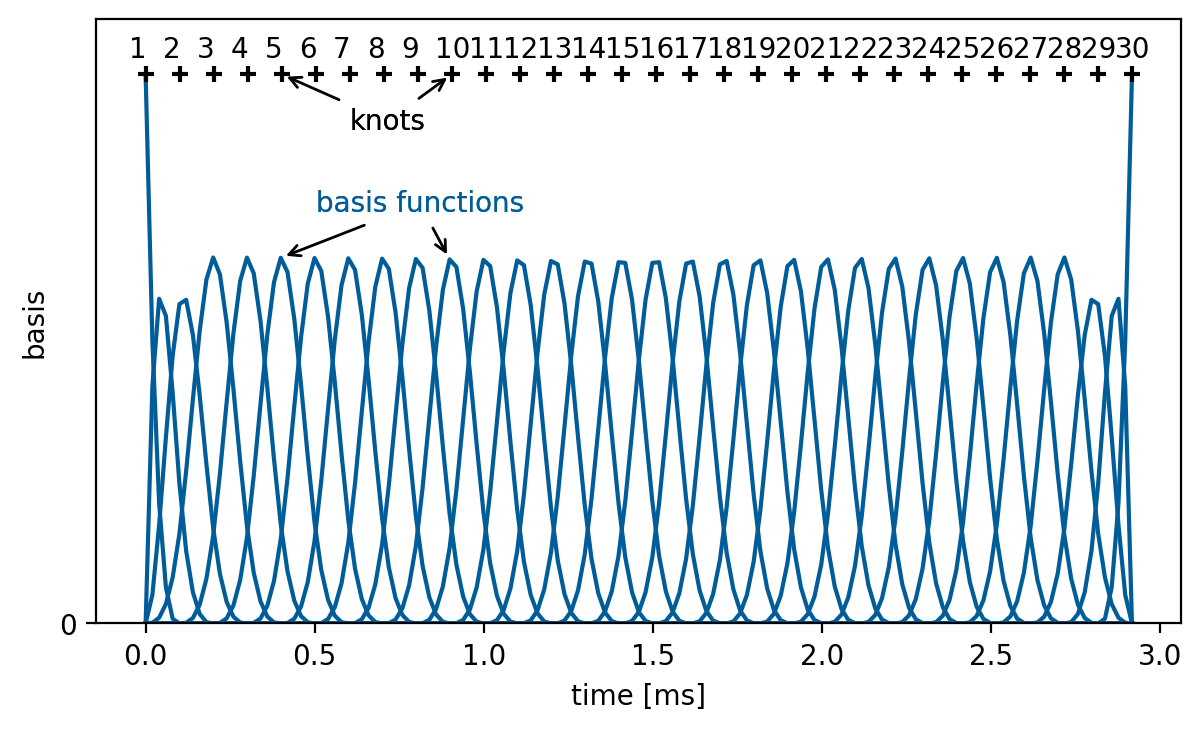

In [47]:
time = signals_healthy_x[0]
knot_list = np.quantile(time, np.linspace(0, 1, num_knots))
B0_healthy = create_spline_matrix(time, spl_order, num_knots)
B0_healthy = B0_healthy.reshape(len(time),num_knots+2)

fig, ax = plt.subplots(1, 1, figsize=(7, 4))
for i in range(num_knots + 2):
    ax.plot(time, (B0_healthy[:, i]), color=DARK, zorder=0)
    if i < num_knots:
        ax.text(s="{}".format(i + 1), x=knot_list[i] - 0.05, y=1.03)
        ax.scatter(knot_list[i], 1, marker="+", color="black", zorder=1)
ax.set_yticks([0, 3])
ax.set_ylim((0, 1.1))
ax.annotate(
    text="knots",
    xy=(knot_list[4], 1),
    xytext=(knot_list[6], 0.9),
    arrowprops={"arrowstyle": "->"},
)
ax.annotate(
    text="knots",
    xy=(knot_list[9], 1),
    xytext=(knot_list[6], 0.9),
    arrowprops={"arrowstyle": "->"},
)

ax.annotate(
    text="basis functions",
    xy=(time[np.argmax(B0_healthy[:, 5])], np.max(B0_healthy[:, 5])),
    xytext=(knot_list[5], 0.75),
    arrowprops={"arrowstyle": "->"},
    c=DARK,
)
ax.annotate(
    text="basis functions",
    xy=(time[np.argmax(B0_healthy[:, 10])], np.max(B0_healthy[:, 10])),
    xytext=(knot_list[5], 0.75),
    arrowprops={"arrowstyle": "->"},
    c=DARK,
)


ax.set_xlabel("time [ms]")
ax.set_ylabel("basis")
fig.savefig("figures/spline_base_damaged_2rods_longest.pdf", bbox_inches="tight")
fig.savefig('figures/spline_base_damaged_2rods_longest.png')


In [12]:
total_len = np.sum(N).astype(int)
total_len_labeled = np.sum(N_labeled).astype(int)
total_len_test = np.sum(N_test).astype(int)
K = num_knots+2
M = 4

In [13]:
mix1 = CmdStanModel(stan_file="spline_mix_2.stan")


INFO:cmdstanpy:found newer exe file, not recompiling


In [14]:
data_out = {
    "I": I,
    "IL": IL,
    "N": N,
    "N_labeled": N_labeled,
    "total_len": total_len,
    "total_len_labeled": total_len_labeled,
    "K": K,
    "M": M,
    "x": B0,
    "y": y,
    "labels": labels, 
    "x_labeled": B0_labeled,
    "y_labeled": y_labeled,
    "lambda0": lambda0,
    "IT": IT,
    "N_test":N_test,
    "x_test": B0_test,
    "y_test": y_test,
    "total_len_test": total_len_test
}
mx2_result = mix1.sample(data=data_out, seed=7122022,max_treedepth=20)

INFO:cmdstanpy:CmdStan start processing


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

INFO:cmdstanpy:CmdStan done processing.


In [15]:
probs_from_arviz = az.summary(
    mx2_result, "log_probabilities", kind='stats', round_to=5)
probs_from_arviz_p = az.summary(
    mx2_result, "probabilities", kind='stats', round_to=5)

In [16]:
indices_cat1 = y_rest_labels[sampling_order_5[I:]] == 1
indices_cat2 = y_rest_labels[sampling_order_5[I:]] == 2
indices_cat3 = y_rest_labels[sampling_order_5[I:]] == 3
indices_cat4 = y_rest_labels[sampling_order_5[I:]] == 4

cat1 = probs_from_arviz.iloc[:IT, :].iloc[indices_cat1, :]
cat2 = probs_from_arviz.iloc[IT:2*IT, :].iloc[indices_cat2, :]
cat3 = probs_from_arviz.iloc[2*IT:3*IT, :].iloc[indices_cat3, :]
cat4 = probs_from_arviz.iloc[3*IT:, :].iloc[indices_cat4, :]

cat1p = probs_from_arviz_p.iloc[:IT, :].iloc[indices_cat1, :]
cat2p = probs_from_arviz_p.iloc[IT:2*IT, :].iloc[indices_cat2, :]
cat3p = probs_from_arviz_p.iloc[2*IT:3*IT, :].iloc[indices_cat3, :]
cat4p = probs_from_arviz_p.iloc[3*IT:, :].iloc[indices_cat4, :]


a = sum((cat1["mean"].values) < np.log(0.5))
b = sum((cat2["mean"].values) < np.log(0.5))
c = sum((cat3["mean"].values) < np.log(0.5))
d = sum((cat4["mean"].values) < np.log(0.5))
print(sum((cat1["mean"].values) < np.log(0.5)))
print(sum((cat2["mean"].values) < np.log(0.5)))
print(sum((cat3["mean"].values) < np.log(0.5)))
print(sum((cat4["mean"].values) < np.log(0.5)))
hit_rate = 1 - (a+b+c+d)/(43-I-IL)
print('hit rate = ',hit_rate)


5
4
5
8
hit rate =  0.18518518518518523


In [17]:
lambda_summary = az.summary(mx2_result, var_names=[
    'lambda'], filter_vars='like').drop(['mcse_sd', 'hdi_3%', 'hdi_97%'], axis=1)
lambda_summary.index = ['$\lambda_1$', '$\lambda_2$','$\lambda_3$', '$\lambda_4$']
lambda_summary.columns = [
    'mean', 'st. dev.',	'$\widehat{\mathrm{MCSE}}$',	'ESS (bulk)', 'ESS (tail)',	'$\widehat{R}$']
lambda_summary

tex_file = open(
    "tables/table_lambda_summary.tex", "w")
n = tex_file.write(lambda_summary.to_latex(escape=False))
tex_file.close()



C:\Users\kjarz\AppData\Local\Temp/ipykernel_37280/2171178811.py:10: FutureWarning: In future versions `DataFrame.to_latex` is expected to utilise the base implementation of `Styler.to_latex` for formatting and rendering. The arguments signature may therefore change. It is recommended instead to use `DataFrame.style.to_latex` which also contains additional functionality.
  n = tex_file.write(lambda_summary.to_latex(escape=False))


In [18]:
lambda_summary

,mean,st. dev.,$\widehat{\mathrm{MCSE}}$,ESS (bulk),ESS (tail),$\widehat{R}$
$\lambda_1$,0.247,0.171,0.002,4621.0,2309.0,1.0
$\lambda_2$,0.052,0.093,0.001,2403.0,1267.0,1.0
$\lambda_3$,0.049,0.090,0.001,2267.0,1439.0,1.0
$\lambda_4$,0.652,0.195,0.003,5144.0,3064.0,1.0


In [19]:
sigma_summary = az.summary(mx2_result, var_names=[
    'sigma'], filter_vars='like').drop(['mcse_sd', 'hdi_3%', 'hdi_97%'], axis=1)
sigma_summary.index = ['$\sigma_1$', '$\sigma_2$','$\lambda_3$', '$\lambda_4$']
sigma_summary.columns = [
    'mean', 'st. dev.',	'$\widehat{\mathrm{MCSE}}$',	'ESS (bulk)', 'ESS (tail)',	'$\widehat{R}$']
sigma_summary

tex_file = open(
    "tables/table_sigma_summary.tex", "w")
n = tex_file.write(sigma_summary.to_latex(escape=False))
tex_file.close()

C:\Users\kjarz\AppData\Local\Temp/ipykernel_37280/4163067050.py:10: FutureWarning: In future versions `DataFrame.to_latex` is expected to utilise the base implementation of `Styler.to_latex` for formatting and rendering. The arguments signature may therefore change. It is recommended instead to use `DataFrame.style.to_latex` which also contains additional functionality.
  n = tex_file.write(sigma_summary.to_latex(escape=False))


In [20]:
sigma_summary

,mean,st. dev.,$\widehat{\mathrm{MCSE}}$,ESS (bulk),ESS (tail),$\widehat{R}$
$\sigma_1$,0.036,0.002,0.0,3559.0,2701.0,1.0
$\sigma_2$,0.120,0.007,0.0,2949.0,3019.0,1.0
$\lambda_3$,0.076,0.003,0.0,3119.0,2902.0,1.0
$\lambda_4$,0.035,0.001,0.0,3929.0,2958.0,1.0


In [21]:
beta_1 = az.summary(mx2_result, var_names=['beta']).filter(
    like=', 0]', axis=0).loc[:, 'mean':'hdi_97%']

beta_2 = az.summary(mx2_result, var_names=['beta']).filter(
    like=', 1]', axis=0).loc[:, 'mean':'hdi_97%']

beta_3 = az.summary(mx2_result, var_names=['beta']).filter(
    like=', 2]', axis=0).loc[:, 'mean':'hdi_97%']

beta_4 = az.summary(mx2_result, var_names=['beta']).filter(
    like=', 3]', axis=0).loc[:, 'mean':'hdi_97%']
betas = [beta_1,beta_2,beta_3,beta_4]


In [22]:
beta_1.index = ['$\\beta_{1,'+str(k)+'}$' for k in range(num_knots+2)]
beta_1.columns = ['mean', 'st. dev.', '4\% HDI', '97\% HDI']
tex_file = open(
    "tables/table_beta_1_summary.tex", "w")
n = tex_file.write(beta_1.to_latex(escape=False))
tex_file.close()


C:\Users\kjarz\AppData\Local\Temp/ipykernel_37280/863420340.py:5: FutureWarning: In future versions `DataFrame.to_latex` is expected to utilise the base implementation of `Styler.to_latex` for formatting and rendering. The arguments signature may therefore change. It is recommended instead to use `DataFrame.style.to_latex` which also contains additional functionality.
  n = tex_file.write(beta_1.to_latex(escape=False))


In [23]:
beta_2.index = ['$\\beta_{1,'+str(k)+'}$' for k in range(num_knots+2)]
beta_2.columns = ['mean', 'st. dev.', '4\% HDI', '97\% HDI']
tex_file = open(
    "tables/table_beta_2_summary.tex", "w")
n = tex_file.write(beta_2.to_latex(escape=False))
tex_file.close()


C:\Users\kjarz\AppData\Local\Temp/ipykernel_37280/1758744250.py:5: FutureWarning: In future versions `DataFrame.to_latex` is expected to utilise the base implementation of `Styler.to_latex` for formatting and rendering. The arguments signature may therefore change. It is recommended instead to use `DataFrame.style.to_latex` which also contains additional functionality.
  n = tex_file.write(beta_2.to_latex(escape=False))


In [24]:
beta_3.index = ['$\\beta_{3,'+str(k)+'}$' for k in range(num_knots+2)]
beta_3.columns = ['mean', 'st. dev.', '4\% HDI', '97\% HDI']
tex_file = open(
    "tables/table_beta_3_summary.tex", "w")
n = tex_file.write(beta_3.to_latex(escape=False))
tex_file.close()


C:\Users\kjarz\AppData\Local\Temp/ipykernel_37280/3919132342.py:5: FutureWarning: In future versions `DataFrame.to_latex` is expected to utilise the base implementation of `Styler.to_latex` for formatting and rendering. The arguments signature may therefore change. It is recommended instead to use `DataFrame.style.to_latex` which also contains additional functionality.
  n = tex_file.write(beta_3.to_latex(escape=False))


In [25]:
beta_4.index = ['$\\beta_{4,'+str(k)+'}$' for k in range(num_knots+2)]
beta_4.columns = ['mean', 'st. dev.', '4\% HDI', '97\% HDI']
tex_file = open(
    "tables/table_beta_4_summary.tex", "w")
n = tex_file.write(beta_4.to_latex(escape=False))
tex_file.close()


C:\Users\kjarz\AppData\Local\Temp/ipykernel_37280/3171871854.py:5: FutureWarning: In future versions `DataFrame.to_latex` is expected to utilise the base implementation of `Styler.to_latex` for formatting and rendering. The arguments signature may therefore change. It is recommended instead to use `DataFrame.style.to_latex` which also contains additional functionality.
  n = tex_file.write(beta_4.to_latex(escape=False))


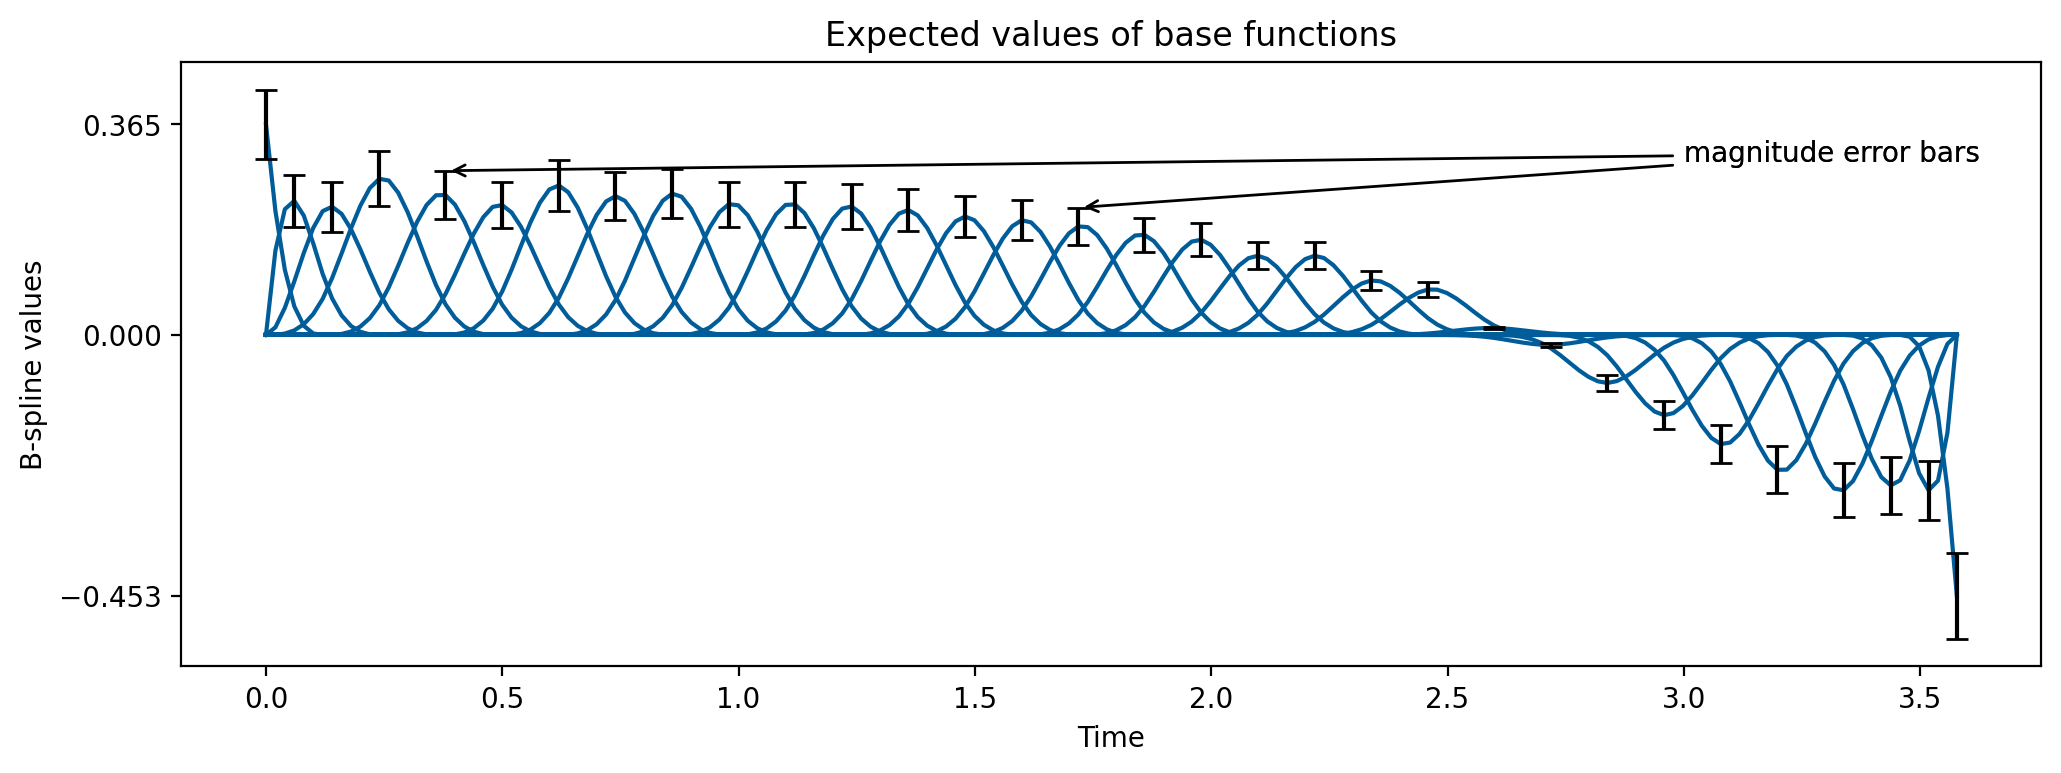

In [49]:
time = signals_healthy_x[0]
knot_list = np.quantile(time, np.linspace(0, 1, num_knots))
B0_healthy = create_spline_matrix(time, spl_order, num_knots)

fig, axes = plt.subplots(1, 1, figsize=(12, 4))
mn_beta = betas[0]['mean'].values
sd_beta = betas[0]['st. dev.'].values
spline_components = B0_healthy@np.diag(mn_beta)
y_m = 0*mn_beta
for i in range(len(y_m)):
    y_m[i] = max(spline_components[:,i].min(), spline_components[:,i].max(), key=abs)
x_m = np.argmax(np.abs(spline_components), axis=0)
for i in range(num_knots+2):
    plt.plot(time,(spline_components[:, i]), color=DARK, zorder=0)
    plt.errorbar(time[x_m[i]], y_m[i], ls='none', yerr=2 * sd_beta[i]*y_m[i], color='black', capsize=4)
plt.ylabel('B-spline values')
plt.annotate(text='magnitude error bars',xy=(time[x_m[4]], y_m[4]+2 * sd_beta[4]*y_m[4]),xytext=(3,0.3),arrowprops={'arrowstyle':'->'})
plt.annotate(text='magnitude error bars',xy=(time[x_m[15]], y_m[15]+2 * sd_beta[7]*y_m[15]),xytext=(3,0.3),arrowprops={'arrowstyle':'->'})
plt.yticks([np.min(spline_components),0,np.max(spline_components)])
plt.title('Expected values of base functions')
plt.xlabel('Time')


fig.savefig('figures/Expected_values_base_fnc.png')
fig.savefig('figures/Expected_values_base_fnc.pdf', bbox_inches="tight")


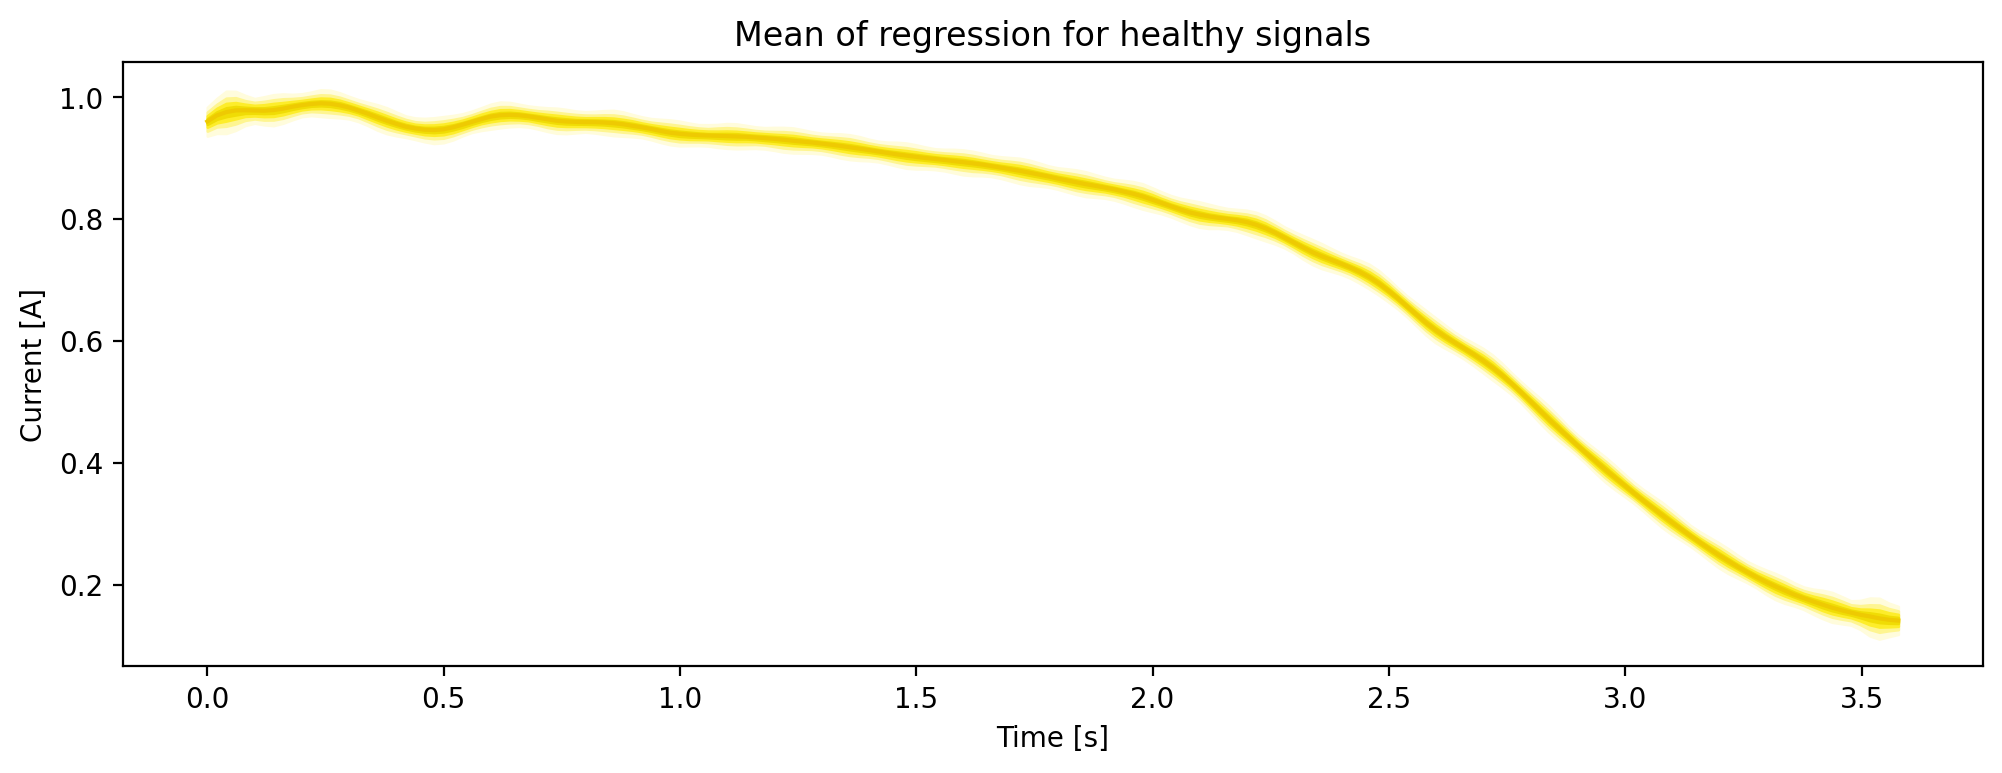

In [50]:
beta_pred= mx2_result.stan_variable('beta')[:,:,0]
alpha_pred = mx2_result.stan_variable('alpha')
time = signals_healthy_x[0]
alpha = np.zeros((4000,len(time)))
for i in range(len(time)):
    alpha[:,i] = alpha_pred
pred = beta_pred@B0_healthy.T + alpha
fig, axes = plt.subplots(1, 1, figsize=(12, 4))

axes = ribbon_plot(time,pred,axes,supress_warning=True)
axes.set_xlabel('Time [s]')
axes.set_ylabel('Current [A]')
axes.set_title('Mean of regression for healthy signals')
plt.show()

fig.savefig('figures/Mean_of_reg_healthy.png')
fig.savefig('figures/Mean_of_reg_healthy.pdf',bbox_inches="tight")



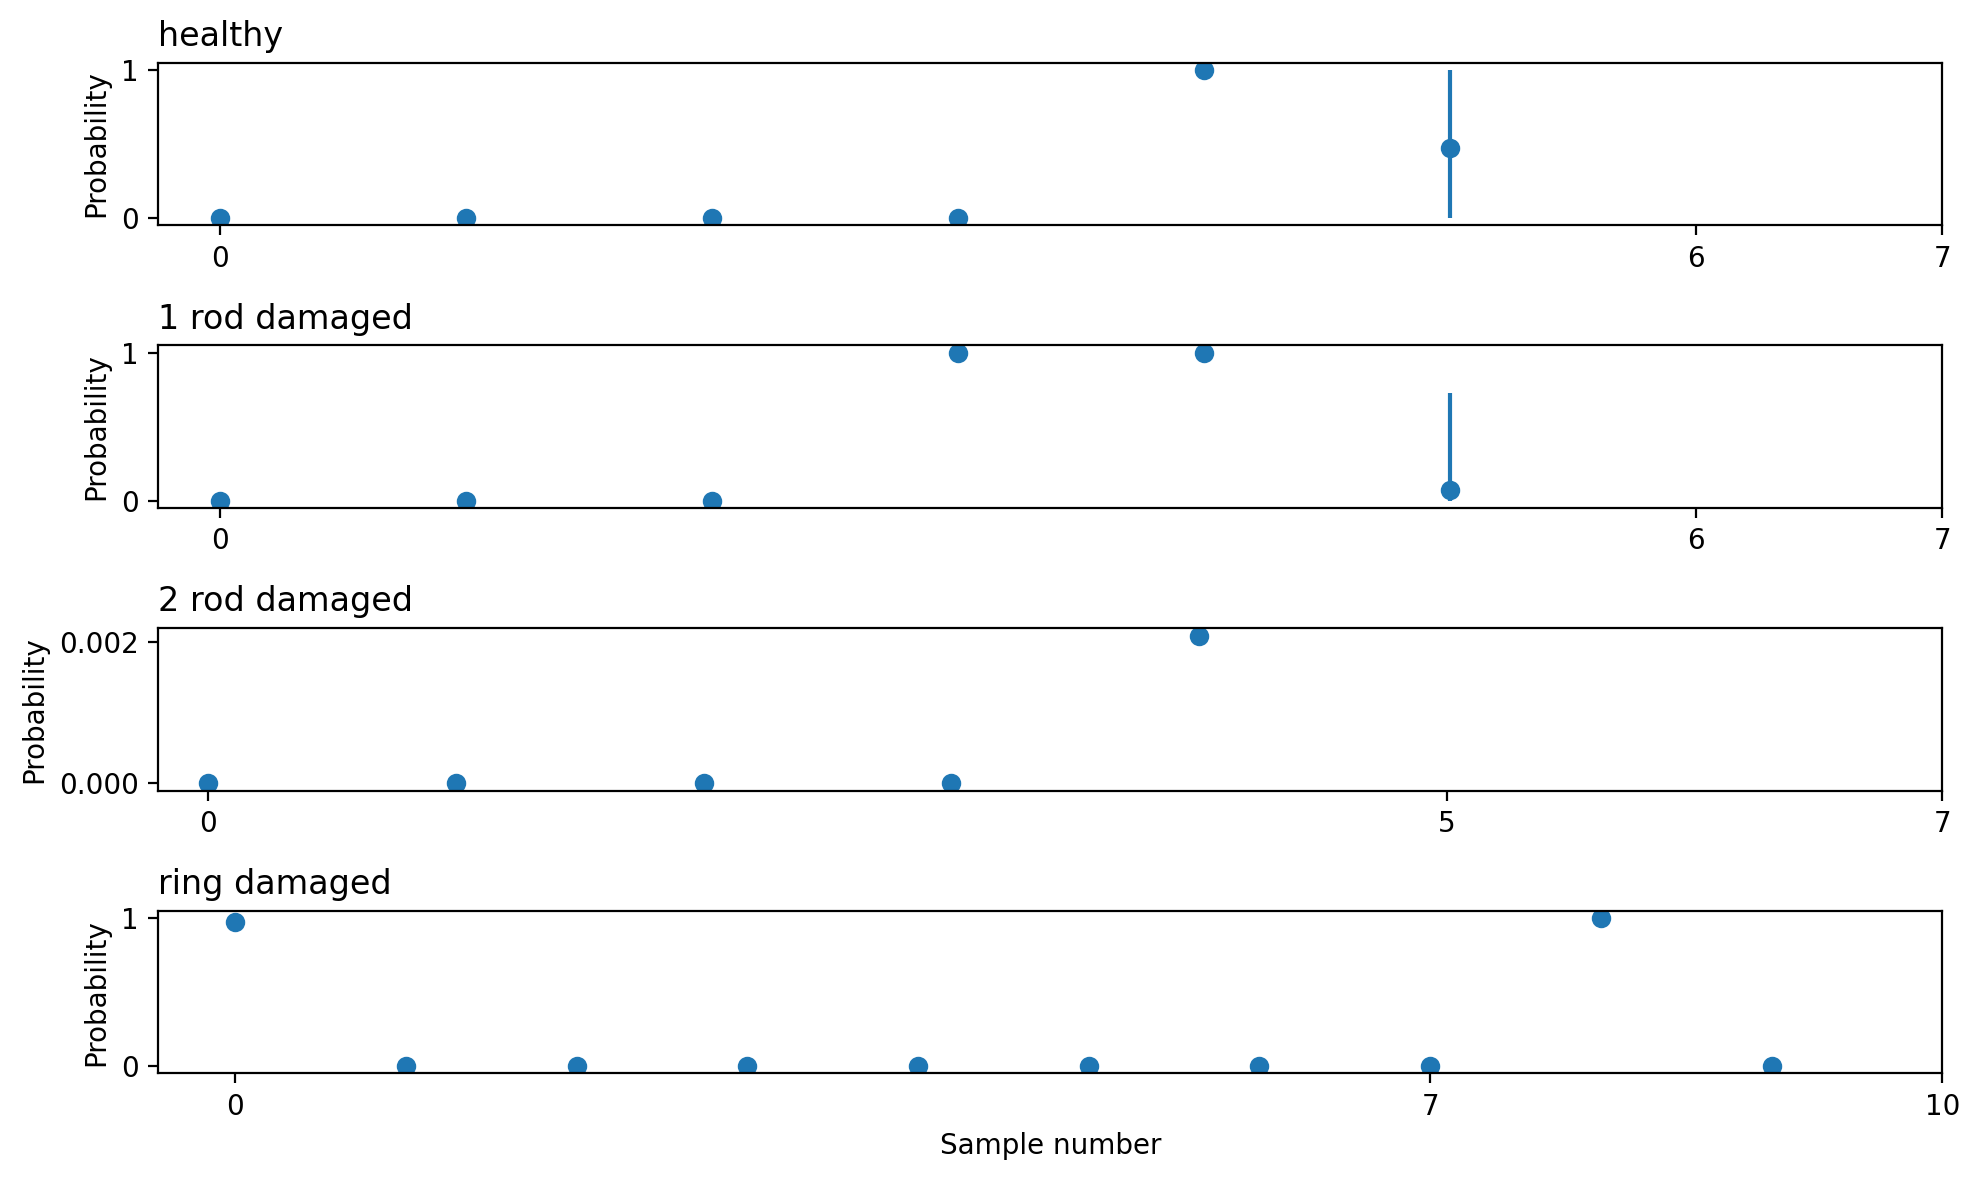

In [46]:
fig, ax = plt.subplots(4,1,figsize=(10,6),tight_layout=True)

x = [*range(len(cat1p))]
ax[0].scatter(x, (cat1p["mean"].values))
ax[0].errorbar(x, cat1p["mean"].values, [cat1p["mean"].values-cat1p["hdi_3%"].values,
             cat1p["hdi_97%"].values-cat1p["mean"].values], linestyle='none')

x = [*range(len(cat2p))]
ax[1].scatter(x, (cat2p["mean"].values))
ax[1].errorbar(x, cat2p["mean"].values, [cat2p["mean"].values-cat2p["hdi_3%"].values,
             cat2p["hdi_97%"].values-cat2p["mean"].values], linestyle='none')


x = [*range(len(cat3p))]
ax[2].scatter(x, (cat3p["mean"].values))
ax[2].errorbar(x, cat3p["mean"].values, [cat3p["mean"].values-cat3p["hdi_3%"].values,
             cat3p["hdi_97%"].values-cat3p["mean"].values], linestyle='none')

x = [*range(len(cat4p))]
ax[3].scatter(x, (cat4p["mean"].values))
ax[3].errorbar(x, cat4p["mean"].values, [cat4p["mean"].values-cat4p["hdi_3%"].values,
             cat4p["hdi_97%"].values-cat4p["mean"].values], linestyle='none')


ax[0].set_title('healthy', loc='left')
ax[0].set_ylabel('Probability')
ax[1].set_title('1 rod damaged', loc='left')
ax[1].set_ylabel('Probability')
ax[2].set_title('2 rod damaged', loc='left')
ax[2].set_ylabel('Probability')
ax[3].set_title('ring damaged', loc='left')
ax[3].set_ylabel('Probability')
ax[3].set_xlabel('Sample number')
ax[0].set_xticks([0,7,len(cat1p)])
ax[1].set_xticks([0,7,len(cat2p)])
ax[2].set_xticks([0,7,len(cat3p)])
ax[3].set_xticks([0,7,len(cat4p)])


fig.savefig('figures/class_result.png')
fig.savefig('figures/class_result.pdf', bbox_inches="tight")


In [ ]:
# print(mx2_result.diagnose())